F. Nammour paper: https://arxiv.org/pdf/2101.10021
F. Nammour code: https://github.com/fadinammour/galaxy2galaxy/tree/radio_data 

https://github.com/CosmoStat/ShapeDeconv/blob/master/data/T-RECS/Generate%20Radio%20ground%20truth%20from%20T-RECS.ipynb



In [31]:
import numpy as np
import galsim
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
from numpy.fft import rfft,fft,fftshift,rfft2,irfft2
# from scipy import random

import astropy.units as u
from astropy.time import Time, TimeDelta

from astropy.coordinates import (
    EarthLocation,
    Angle,
    AltAz,
    ICRS,
    Longitude,
    FK5,
    SkyCoord
)
from astropy.constants import c as lspeed



In [32]:
np.random.seed(42)

Npix=128             # Size of image
pixelscale=.15     # Size of pixel in arcsec on the sky. Helps sampling the images w.r.t. catalogues.
stampimage = galsim.ImageF(Npix, Npix, scale=pixelscale)
b=galsim.BoundsI(1,Npix,1,Npix)
stamp=stampimage[b]


In [33]:
FFTBIGSIZE=81488  # Max size of support for Galsim (Caching the FFT)
big_fft_params=galsim.GSParams(maximum_fft_size=FFTBIGSIZE)   # to precalculate large support.

In [34]:
image = galsim.ImageF(Npix, Npix, scale=pixelscale)
b = galsim.BoundsI(1,Npix,1,Npix)
image = image[b]

In [35]:
catalogsfg=fits.open('../data/catalogue_SFGs_complete_wide1.fits')
catalogsfg.info()

Filename: ../data/catalogue_SFGs_complete_wide1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  Catalogue     1 BinTableHDU    197   4418708R x 47C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [36]:
cat1=catalogsfg[1]               # Selecting the first slice of the Fits ("Catalogue")
catdatasfg=cat1.data             # Extract data from slice
flux1400sfg=catdatasfg['I1400']  # Flux density at 1400 MHz (in Janskys)

sizesfg=catdatasfg['size']       # angular size on the sky (in arcsec)
e1=catdatasfg['e1']              # first ellipticity
e2=catdatasfg['e2'] 

In [37]:
# Filtering objects that are larger than 10 pixels and
# smaller than 70 pixels on the sky.
# typical values for the array and frequency.
minpixsize=3.
maxpixsize=40.
# filter objects with flux density larger than 0.05 mJy and smaller than 0.2 mJy
max_flux=0.2
min_flux=0.05

filterobj=np.logical_and(sizesfg > minpixsize*pixelscale, sizesfg < maxpixsize*pixelscale)
filterobj=np.logical_and(filterobj, flux1400sfg < max_flux) # filter objects with flux density smaller than max_flux
filterobj=np.logical_and(filterobj, flux1400sfg > min_flux)  # filter objects with flux density larger than min_flux

listindexobj=np.where(filterobj == True)[0] # list of indices where condition is true
Ntotobj=len(listindexobj)                   # number of objects fitting the condition
print(Ntotobj)

153499


In [38]:
import scipy.stats as stats

SIZE FIT -  alpha: 3.1888667395713575 beta: 43.24191697232753 loc: 0.22499999999999998 scale: 13.875
FLUX FIT -  alpha: 0.9719302943052706 beta: 16.533137644039233 loc: 0.05 scale: 0.7500000000000001


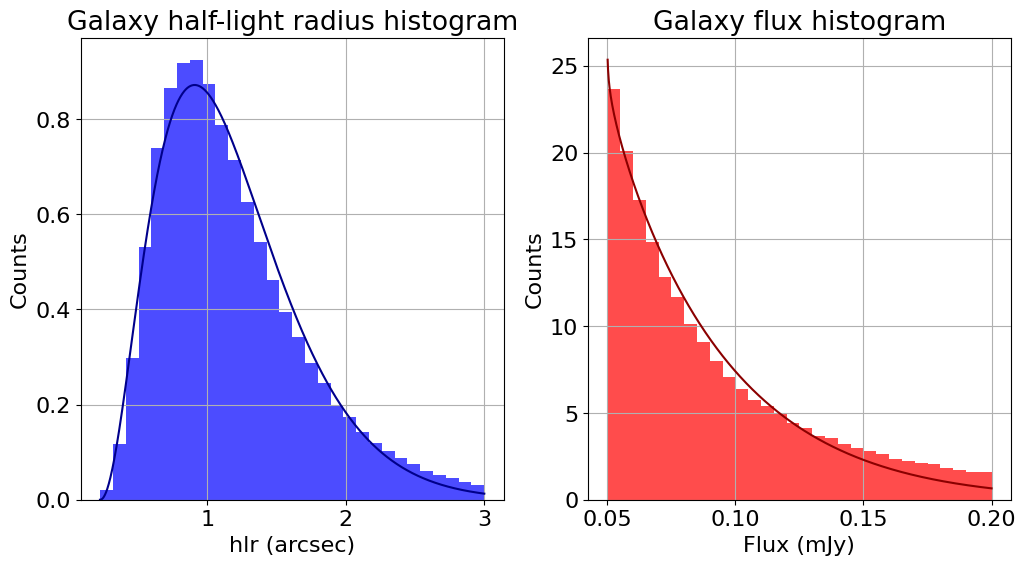

In [39]:
fit_correction = 5.
x_size = np.linspace(minpixsize*pixelscale/2, maxpixsize*pixelscale/2, 1000)
x_flux = np.linspace(min_flux, max_flux, 1000)

plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(sizesfg[listindexobj]/(2), bins=30, alpha=0.7, color='blue', density=True)
plt.xlabel('hlr (arcsec)')
plt.ylabel('Counts')
plt.title('Galaxy half-light radius histogram')
plt.grid(True)
############################################
# Check fit, may need to fix loc and scale #
############################################
alpha_hlr, beta_hlr, loc_hlr, scale_hlr = stats.beta.fit(sizesfg[listindexobj]/(2), floc=minpixsize*pixelscale/2, fscale=(maxpixsize-minpixsize)*pixelscale/2*fit_correction)
print("SIZE FIT - ", "alpha:", alpha_hlr,"beta:", beta_hlr, "loc:", loc_hlr, "scale:", scale_hlr)
plt.plot(x_size, stats.beta.pdf(x_size, alpha_hlr, beta_hlr, loc=loc_hlr, scale=scale_hlr), label='Size PDF', color='darkblue')

plt.subplot(1, 2, 2)
plt.hist(flux1400sfg[listindexobj], bins=30, alpha=0.7, color='red', density=True)
alpha_flux, beta_flux, loc_flux, scale_flux = stats.beta.fit(flux1400sfg[listindexobj], floc=min_flux, fscale=(max_flux-min_flux)*fit_correction)
print("FLUX FIT - ", "alpha:", alpha_flux,"beta:", beta_flux, "loc:", loc_flux, "scale:", scale_flux)
plt.plot(x_flux, stats.beta.pdf(x_flux, alpha_flux, beta_flux, loc=loc_flux, scale=scale_flux), label='Flux PDF', color='darkred')
plt.xlabel('Flux (mJy)')
plt.ylabel('Counts')
plt.title('Galaxy flux histogram')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'T-RECS galaxy parameters distribution')

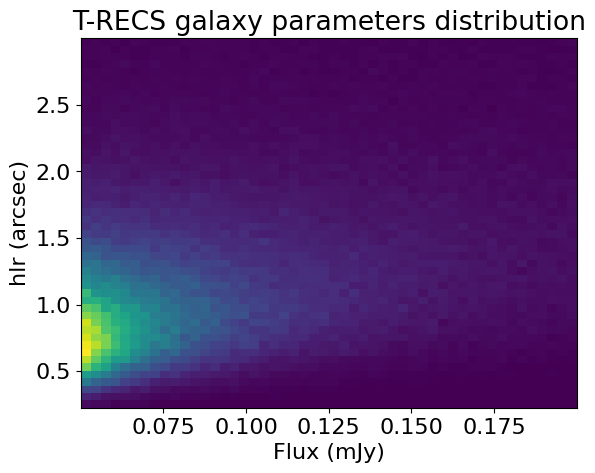

In [40]:
_ = plt.hist2d(flux1400sfg[listindexobj], sizesfg[listindexobj]/(2), bins=50, cmap='viridis', density=True)
plt.xlabel('Flux (mJy)')
plt.ylabel('hlr (arcsec)')
plt.title('T-RECS galaxy parameters distribution')

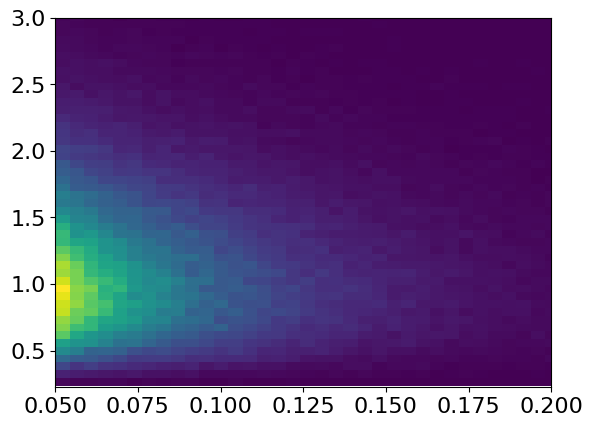

In [41]:
_ = plt.hist2d(stats.beta(alpha_flux, beta_flux, loc=loc_flux, scale=scale_flux).rvs(size=Ntotobj),
            stats.beta(alpha_hlr, beta_hlr, loc=loc_hlr, scale=scale_hlr).rvs(size=Ntotobj), bins=80, cmap='viridis', density=True)
plt.xlim(min_flux, max_flux)
plt.ylim(minpixsize*pixelscale/2, maxpixsize*pixelscale/2)
plt.show()

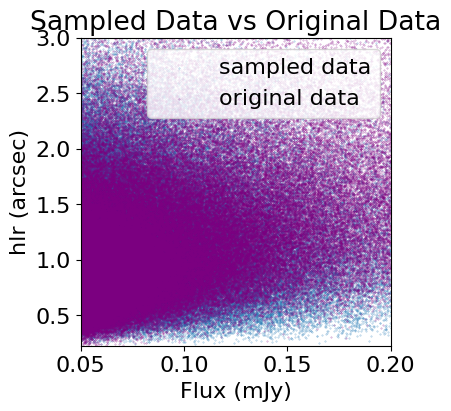

In [42]:
plt.figure(figsize=(4, 4))
plt.scatter(stats.beta(alpha_flux, beta_flux, loc=loc_flux, scale=scale_flux).rvs(size=Ntotobj),
            stats.beta(alpha_hlr, beta_hlr, loc=loc_hlr, scale=scale_hlr).rvs(size=Ntotobj),
            s=.1, alpha=0.5, label="sampled data")
plt.scatter(flux1400sfg[listindexobj], sizesfg[listindexobj]/2, s=.1 ,alpha=0.5, color='purple', label="original data")
plt.ylabel('hlr (arcsec)')
plt.xlabel('Flux (mJy)')
plt.ylim(minpixsize*pixelscale/2, maxpixsize*pixelscale/2)
plt.xlim(min_flux, max_flux)
plt.title('Sampled Data vs Original Data')
plt.legend()
plt.show()

e1 FIT -  alpha: 0.8120078672375124 beta: 0.8977929638852067 loc: -0.9703102111816407 scale: 1.9537627935343969
e2 FIT -  alpha: 1.6715567088283438 beta: 1.7594366790321065 loc: -0.9649832689940873 scale: 1.9278500522230346


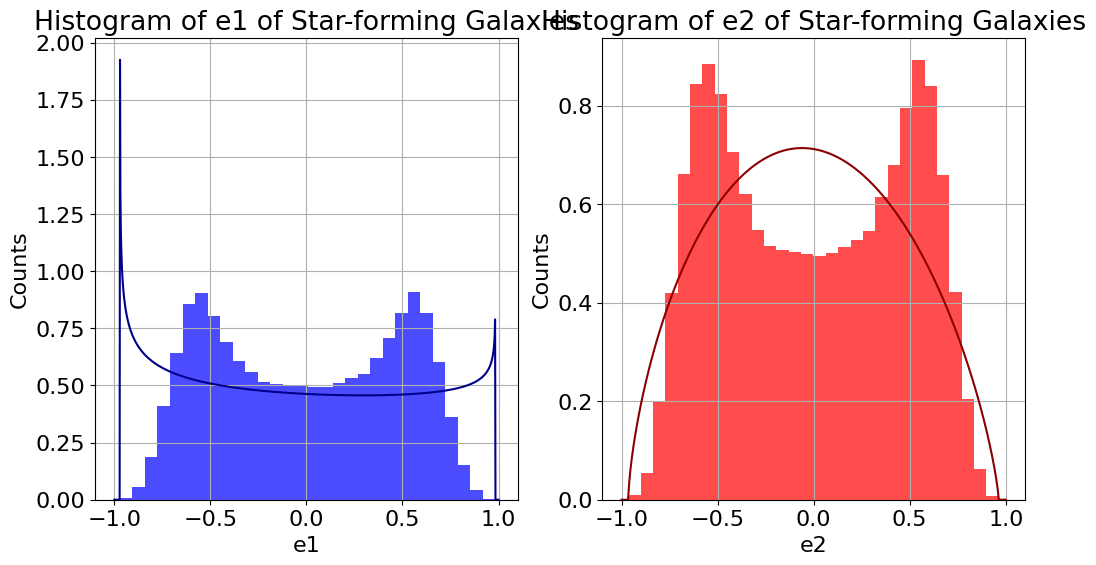

In [43]:
x_ell = np.linspace(-1, 1, 1000)
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(e1[listindexobj], bins=30, alpha=0.7, color='blue', density=True)
plt.xlabel('e1')
plt.ylabel('Counts')
plt.title('Histogram of e1 of Star-forming Galaxies')
plt.grid(True)
alpha_e1, beta_e1, loc_e1, scale_e1 = stats.beta.fit(e1[listindexobj])
print("e1 FIT - ", "alpha:", alpha_e1,"beta:", beta_e1, "loc:", loc_e1, "scale:", scale_e1)
plt.plot(x_ell, stats.beta.pdf(x_ell, alpha_e1, beta_e1, loc=loc_e1, scale=scale_e1), label='e1 PDF', color='darkblue')
plt.subplot(1, 2, 2)
plt.hist(e2[listindexobj], bins=30, alpha=0.7, color='red', density=True)
plt.xlabel('e2')
plt.ylabel('Counts')
plt.title('Histogram of e2 of Star-forming Galaxies')
plt.grid(True)
alpha_e2, beta_e2, loc_e2, scale_e2 = stats.beta.fit(e2[listindexobj])
print("e2 FIT - ", "alpha:", alpha_e2,"beta:", beta_e2, "loc:", loc_e2, "scale:", scale_e2)
plt.plot(x_ell, stats.beta.pdf(x_ell, alpha_e2, beta_e2, loc=loc_e2, scale=scale_e2), label='e2 PDF', color='darkred')
plt.show()

ELLIPTICITY FIT -  (np.float64(20.726495589596606), np.float64(25.99702961732686), 0, 1.5)


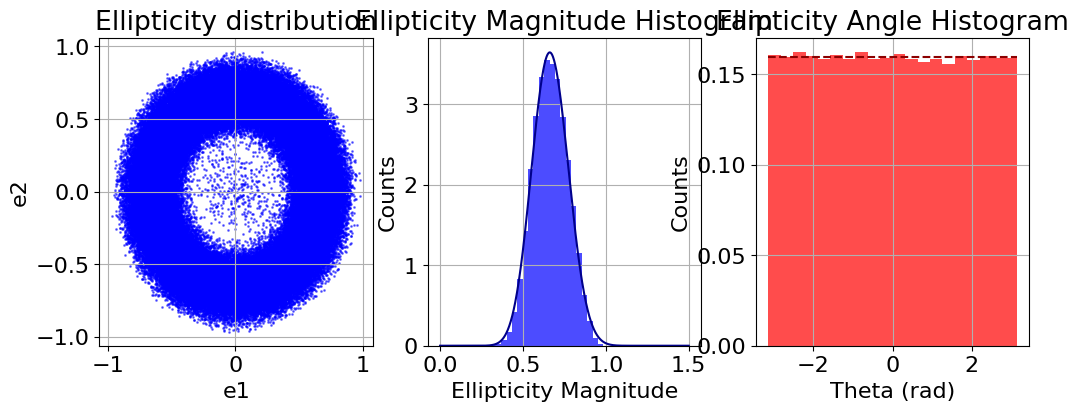

In [44]:
plt.subplots(1,3, figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(e1[listindexobj], e2[listindexobj], alpha=0.5, s=1, color='blue')
plt.xlabel('e1')
plt.ylabel('e2')
plt.title('Ellipticity distribution')
plt.grid(True)

plt.subplot(1, 3, 2)
x_ell_radius = np.linspace(0, 1.5, 1000)
r_ell = np.sqrt(np.array(e1[listindexobj])**2 + np.array(e2[listindexobj])**2)
plt.hist(r_ell, bins=30, alpha=0.7, color='blue', density=True)
plt.xlabel('Ellipticity Magnitude')
plt.ylabel('Counts')
plt.title('Ellipticity Magnitude Histogram')
plt.grid(True)
r_ell_fit_params = stats.beta.fit(r_ell, floc=0, fscale=1.5)
print("ELLIPTICITY FIT - ", r_ell_fit_params)
plt.plot(x_ell_radius, stats.beta.pdf(x_ell_radius, *r_ell_fit_params), label='Ellipticity PDF', color='darkblue')

plt.subplot(1, 3, 3)
x_ell_angle = np.linspace(-np.pi, np.pi, 1000)
theta_ell = np.arctan2(e2[listindexobj], e1[listindexobj])
plt.hist(theta_ell, bins=20, alpha=0.7, color='red', density=True)
plt.xlabel('Theta (rad)')
plt.ylabel('Counts')
plt.title('Ellipticity Angle Histogram')
plt.grid(True)
plt.hlines(1/(2*np.pi), -np.pi, np.pi, color='darkred', linestyle='--', label='Uniform Distribution')
plt.show()

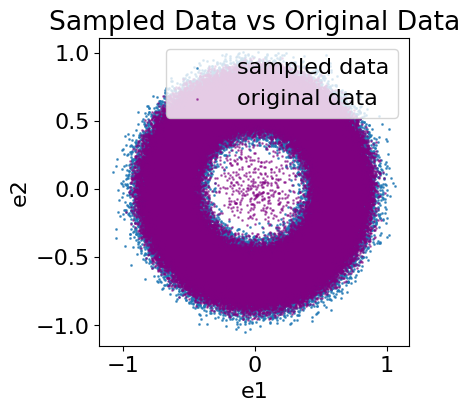

In [45]:
r_samples = stats.beta(*r_ell_fit_params).rvs(size=Ntotobj)
theta_samples = np.random.uniform(-np.pi, np.pi, size=Ntotobj)
e1_samples = r_samples * np.cos(theta_samples)
e2_samples = r_samples * np.sin(theta_samples)
plt.figure(figsize=(4, 4))
plt.scatter(e1_samples, e2_samples, s=1, alpha=0.7, label="sampled data")
plt.scatter(e1[listindexobj], e2[listindexobj], s=1 ,alpha=0.5, color='purple', label="original data")
plt.xlabel('e1')
plt.ylabel('e2')
plt.title('Sampled Data vs Original Data')
plt.legend(loc='upper right')
plt.show()

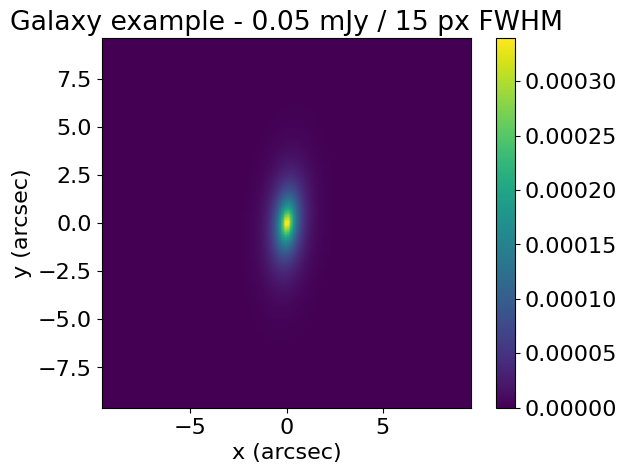

In [46]:
IDXsource = listindexobj[np.random.randint(0,Ntotobj)]  # Randomly select an object from the list

# Generate Star-forming galaxies (T-RECS) and plotting
f=plt.figure()
fluxsource=flux1400sfg[IDXsource]
e1gal=e1[IDXsource]
e2gal=e2[IDXsource]

ellipticity = galsim.Shear(e1=e1gal,e2=e2gal)
# as the object is "fully" defined manually, a better galsim approach can be done here:
# gauss_gal=galsim.Gaussian(fwhm=sizesfg[IDXsource],flux=fluxsource)
# gal = galsim.Exponential(half_light_radius=gauss_gal.half_light_radius, flux=fluxsource, gsparams=big_fft_params)
gal = galsim.Exponential(half_light_radius=sizesfg[IDXsource]/2, flux=fluxsource, gsparams=big_fft_params)
ellipticity = galsim.Shear(e1=e1gal,e2=e2gal)
gal = gal.shear(ellipticity)
gal2=gal.drawImage(stamp,scale=pixelscale)
plt.imshow(gal2.array, extent=[-Npix*pixelscale/2,Npix*pixelscale/2,-Npix*pixelscale/2,Npix*pixelscale/2], cmap='viridis')
plt.title('Galaxy example - {:.2f} mJy / {:.0f} px FWHM'.format(fluxsource, sizesfg[IDXsource]/pixelscale))
plt.colorbar()
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')
plt.show()

In [47]:
trecs_gal_params = {
    'pixelscale': pixelscale,
    'Npix': Npix,
    'min_pix_size': minpixsize,
    'max_pix_size': maxpixsize,
    'beta_fit_hlr': {
        'a': alpha_hlr, 
        'b': beta_hlr, 
        'loc': loc_hlr, 
        'scale': scale_hlr,
        },
    'min_flux': min_flux,
    'max_flux': max_flux,
    'beta_fit_flux': {
        'a': alpha_flux, 
        'b': beta_flux, 
        'loc': loc_flux, 
        'scale': scale_flux
        },
    'beta_fit_r_ell': {
        'a': r_ell_fit_params[0],
        'b': r_ell_fit_params[1],
        'loc': r_ell_fit_params[2],
        'scale': r_ell_fit_params[3]
        },
    }
    
np.save('../data/trecs_gal_params.npy', trecs_gal_params, allow_pickle=True)

In [17]:
hlr_fit_ = trecs_gal_params['beta_fit_hlr']
flux_fit_ = trecs_gal_params['beta_fit_flux']


0.13904102


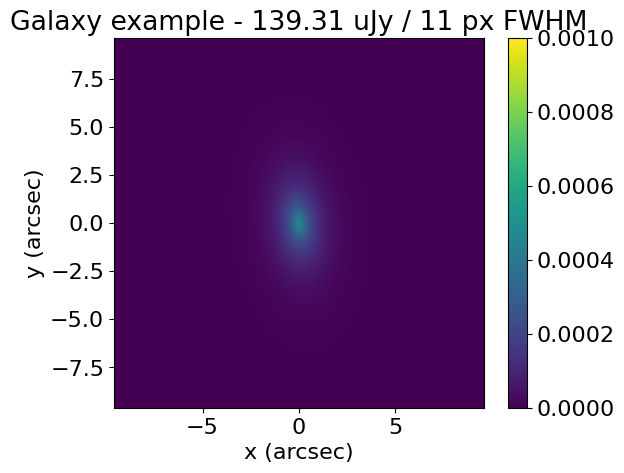

In [18]:
hlr = stats.beta(hlr_fit_['a'], hlr_fit_['b']).rvs()*hlr_fit_['scale'] + hlr_fit_['loc'] 
flux= stats.beta(flux_fit_['a'], flux_fit_['b']).rvs()*flux_fit_['scale'] + flux_fit_['loc']

gal = galsim.Exponential(
    half_light_radius= hlr,  # Convert FWHM to half-light radius
    flux=flux,
)

plt.rcParams.update({'font.size': 16})
ellipticity = galsim.Shear(e1=e1gal,e2=e2gal)
gal = gal.shear(ellipticity)
gal2=gal.drawImage(stamp,scale=pixelscale)
# gal2 = gal2*flux/np.sum(gal2.array)  # Scale the flux to the desired value
print(np.sum(gal2.array))
plt.imshow(gal2.array, extent=[-Npix*pixelscale/2,Npix*pixelscale/2,-Npix*pixelscale/2,Npix*pixelscale/2], 
           cmap='viridis',
           vmax=0.001
           )
plt.title('Galaxy example - {:.2f} uJy / {:.0f} px FWHM'.format(flux*1e3, hlr /pixelscale))
plt.colorbar()
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')
plt.show()

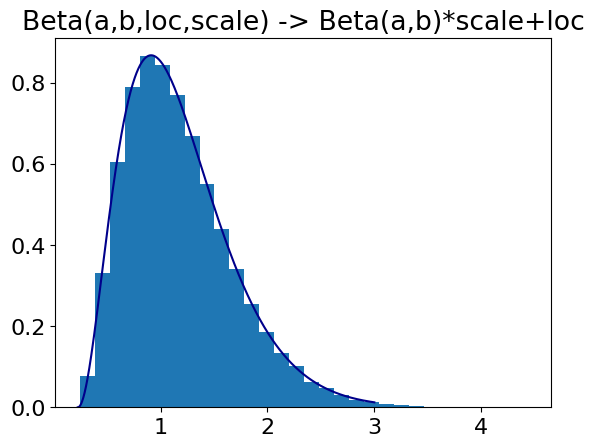

In [19]:
plt.plot(x_size, stats.beta.pdf(x_size, alpha_hlr, beta_hlr, loc=loc_hlr, scale=scale_hlr), label='Size PDF', color='darkblue')
plt.hist(stats.beta(alpha_hlr, beta_hlr).rvs(size=Ntotobj)*scale_hlr+loc_hlr, bins=30, density=True)
plt.title('Beta(a,b,loc,scale) -> Beta(a,b)*scale+loc')
plt.show()

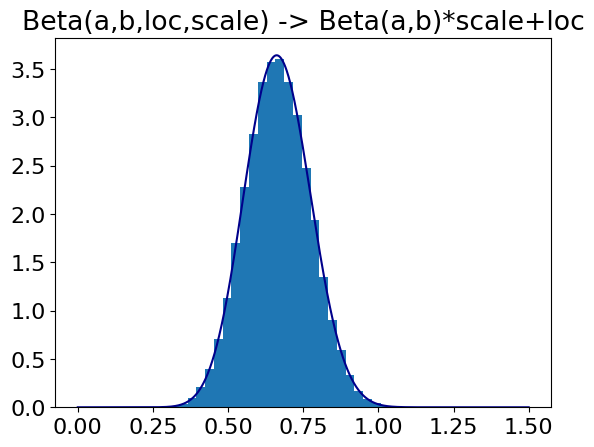

In [20]:
plt.plot(x_ell_radius, stats.beta.pdf(x_ell_radius, *r_ell_fit_params), label='Size PDF', color='darkblue')
plt.hist(stats.beta(r_ell_fit_params[0], r_ell_fit_params[1]).rvs(size=Ntotobj)*r_ell_fit_params[3]+r_ell_fit_params[2], bins=30, density=True)
plt.title('Beta(a,b,loc,scale) -> Beta(a,b)*scale+loc')
plt.show()

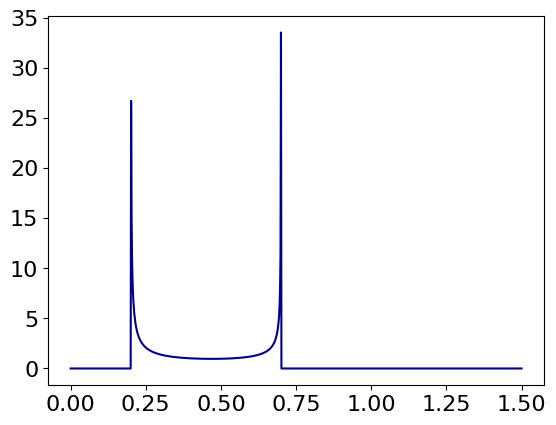

In [21]:
plt.plot(x_ell_radius, stats.beta.pdf(x_ell_radius, .3, .4, loc=.2, scale=.5), label='Size PDF', color='darkblue')
